In [135]:
import pandas as pd
import plotly.express as px
import json
import networkx as nx
import matplotlib.pyplot as plt
import copy
import matplotlib.ticker as mtick
import numpy as np
import scipy.optimize as opt

In [136]:
# Read /Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_Nodes.csv
nodes_df = pd.read_csv('Scigrid_data/IGGIN_Nodes.csv', delimiter=';')

# Drop the following columns: param, uncertainty, method, tags
nodes_df = nodes_df.drop(columns=['param', 'uncertainty', 'method', 'tags'])

In [137]:
# Read /Users/johanmasvie/programming/tiø4900/master_thesis/Scigrid_data/IGGIN_PipeSegments.csv
pipe_segments_df = pd.read_csv('Scigrid_data/IGGIN_PipeSegments.csv', delimiter=';')

# Split the 'param' column into separate columns
pipe_segments_df['param'] = pipe_segments_df['param'].apply(lambda x: json.loads(x.replace("'", '"')))
param_df = pd.json_normalize(pipe_segments_df['param'])
pipe_segments_df = pipe_segments_df.drop(columns=['param']).join(param_df)

# Drop the method, uncertainty and tags columns
pipe_segments_df = pipe_segments_df.drop(columns=['method', 'uncertainty', 'tags', 'source_id'])

# Evaluate the node_id column as a list of two strings and split it into two separate columns
pipe_segments_df['node_id'] = pipe_segments_df['node_id'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['node_id'] = pipe_segments_df['node_id'].apply(lambda x: [str(i) for i in x])
pipe_segments_df['from_node_id'] = pipe_segments_df['node_id'].apply(lambda x: x[0])
pipe_segments_df['to_node_id'] = pipe_segments_df['node_id'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['node_id'])

# Evaluate the country_code column as a list of two strings and split it into two separate columns
pipe_segments_df['country_code'] = pipe_segments_df['country_code'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['country_code'] = pipe_segments_df['country_code'].apply(lambda x: [str(i) for i in x])
pipe_segments_df['from_country_code'] = pipe_segments_df['country_code'].apply(lambda x: x[0])
pipe_segments_df['to_country_code'] = pipe_segments_df['country_code'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['country_code'])

# Evaluate the lat and long columns as lists of two floats and split them into two separate columns
pipe_segments_df['lat'] = pipe_segments_df['lat'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['lat'] = pipe_segments_df['lat'].apply(lambda x: [float(i) for i in x])
pipe_segments_df['from_lat'] = pipe_segments_df['lat'].apply(lambda x: x[0])
pipe_segments_df['to_lat'] = pipe_segments_df['lat'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['lat'])

pipe_segments_df['long'] = pipe_segments_df['long'].apply(lambda x: json.loads(x.replace("'", '"')))
pipe_segments_df['long'] = pipe_segments_df['long'].apply(lambda x: [float(i) for i in x])
pipe_segments_df['from_long'] = pipe_segments_df['long'].apply(lambda x: x[0])
pipe_segments_df['to_long'] = pipe_segments_df['long'].apply(lambda x: x[1])
pipe_segments_df = pipe_segments_df.drop(columns=['long'])

In [138]:
# Create a networkx graph using the nodes_df as nodes and the pipe_segments_df as edges
G_multi_digraph = nx.MultiDiGraph()

# Add nodes to the graph
for index, row in nodes_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the node
    attributes = dict(row)
    G_multi_digraph.add_node(row['id'], **attributes)

# Add edges to the graph
for index, row in pipe_segments_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the edge
    attributes = dict(row)
    G_multi_digraph.add_edge(row['from_node_id'], row['to_node_id'], **attributes)

# # Iterate over the edges once more: if the is_bothDirection is 1.0, add the edge in the opposite direction
for index, row in pipe_segments_df.iterrows():
    if row['is_bothDirection'] == 1.0:
        G_multi_digraph.add_edge(row['to_node_id'], row['from_node_id'], **dict(row))

# Print number of edges in the graph
print('Number of edges in the graph:', G_multi_digraph.number_of_edges())
# Print number of rows in the pipe_segments_df
print('Number of rows in the pipe_segments_df:', len(pipe_segments_df))

Number of edges in the graph: 1007
Number of rows in the pipe_segments_df: 962


In [139]:
# Plot the nodes and edges of the graph, using the lat and long attributes of the nodes
pos = {node: (G_multi_digraph.nodes[node]['long'], G_multi_digraph.nodes[node]['lat']) for node in G_multi_digraph.nodes}
# nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue')
# plt.show()

In [140]:
# Plot the graph, but this time color code the different connected components of the graph, i.e., let each connected component have a different color
components = nx.weakly_connected_components(G_multi_digraph)
colors = {node: 0 for node in G_multi_digraph.nodes}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# nx.draw(G, pos, with_labels=False, node_size=10, node_color=list(colors.values()))
# plt.show()

In [141]:
"""
Merge the following nodes:

- NO_N_33 and INET_N_407
- NO_N_5 and INET_N_1656
- NO_N_27, Storages_0, and INET_N_379
- NO_N_19 and INET_N_436
- NO_N_39 and INET_N_410
- NO_N_24 and INET_N_1401


"""

# Merge the nodes
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_33', 'INET_N_407')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_5', 'INET_N_1656')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_27', 'INET_N_379')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_27', 'Storages_0')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_19', 'INET_N_436')
G_multi_digraphG = nx.contracted_nodes(G_multi_digraph, 'NO_N_39', 'INET_N_410')
G_multi_digraph = nx.contracted_nodes(G_multi_digraph, 'NO_N_24', 'INET_N_1401')

In [142]:
# Plot the graph, but this time color code the different connected components of the graph, i.e., let each connected component have a different color
components = nx.weakly_connected_components(G_multi_digraph)
colors = {node: 0 for node in G_multi_digraph.nodes}
for i, component in enumerate(components):
    for node in component:
        colors[node] = i

# nx.draw(G, pos, with_labels=False, node_size=10, node_color=list(colors.values()))
# plt.show()

In [143]:
# Create a new graph consisting of only the largest connected component of the graph
largest_connected_component = max(nx.weakly_connected_components(G_multi_digraph), key=len)
G_multi_digraph = G_multi_digraph.subgraph(largest_connected_component)

# As the graph is a directed multigraph, and the max-flow only works on directed graphs, we need to convert the graph to a directed graph.
# Aggregating the edges with the same from_node_id and to_node_id, and summing the capacity attribute of the edges
G_simple_directed = nx.DiGraph()
for from_node in G_multi_digraph.nodes:
    for to_node in G_multi_digraph.nodes:
        if G_multi_digraph.has_edge(from_node, to_node):
            if G_simple_directed.has_edge(from_node, to_node):
                G_simple_directed[from_node][to_node]['max_cap_M_m3_per_d'] += G_multi_digraph[from_node][to_node][0]['max_cap_M_m3_per_d']
            else:
                G_simple_directed.add_edge(from_node, to_node, max_cap_M_m3_per_d=G_multi_digraph[from_node][to_node][0]['max_cap_M_m3_per_d'])

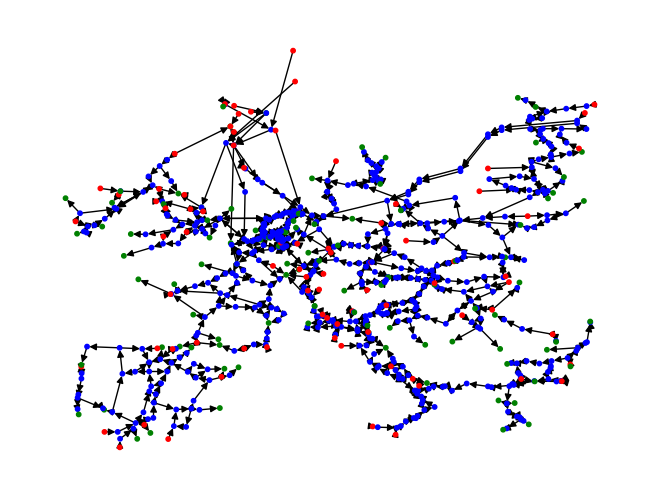

In [144]:
# Plot the G_largest graph. However, this time around, let nodes with in-degree 0 have a certain color, nodes with out-degree 0 have a certain color, and nodes with both in-degree and out-degree 0 have a certain color
in_degree = dict(G_simple_directed.in_degree())
out_degree = dict(G_simple_directed.out_degree())
node_colors = {node: 'blue' for node in G_simple_directed.nodes}
for node in G_simple_directed.nodes:
    if in_degree[node] == 0:
        node_colors[node] = 'red'
    if out_degree[node] == 0:
        node_colors[node] = 'green'
    if in_degree[node] == 0 and out_degree[node] == 0:
        node_colors[node] = 'yellow'

nx.draw(G_simple_directed, pos, with_labels=False, node_size=10, node_color=list(node_colors.values()))
plt.show()

In [145]:
# Solve the max-flow problem on the G_simple_directed graph

# Define the source and sink nodes, as the nodes with 0 in-degree and 0 out-degree, respectively
sources = [node for node in G_simple_directed.nodes if in_degree[node] == 0]
sinks = [node for node in G_simple_directed.nodes if out_degree[node] == 0]

# Solve the max-flow problem
def solve_MFMSS(graph, sources, sinks):
    
    # Create a copy of the graph with the same nodes, edges, and edge attributes
    graph_ = copy.deepcopy(graph)

    # Create a super-source and super-sink
    graph_.add_node('super_source')
    graph_.add_node('super_sink')

    # Add edges from the super-source to the sources and from the sinks to the super-sink
    for source in sources:
        graph_.add_edge('super_source', source, max_cap_M_m3_per_d=float('inf'))
    for sink in sinks:
        graph_.add_edge(sink, 'super_sink', max_cap_M_m3_per_d=float('inf'))
    
    # Return the solution to the max-flow problem
    return nx.maximum_flow(graph_, 'super_source', 'super_sink', capacity='max_cap_M_m3_per_d')

# Solve the max-flow problem
flow_value, flow_dict = solve_MFMSS(G_simple_directed, sources, sinks)

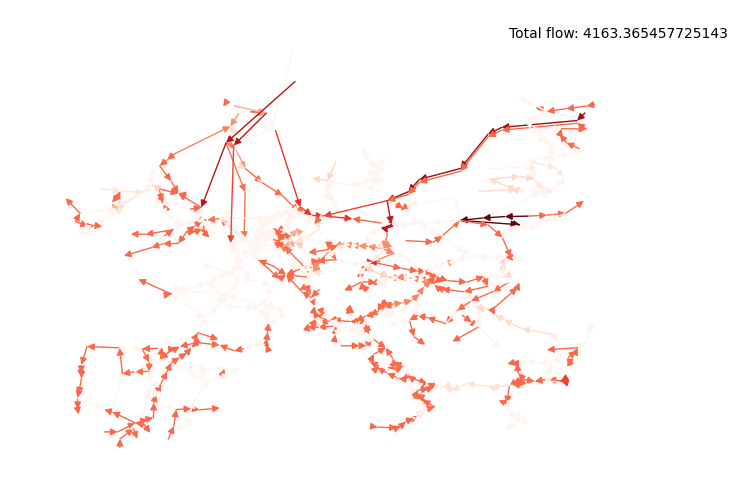

In [146]:
# Using the solution to the max-flow problem, create a new graph, coloring the edges with flow > 0 red, and the edges with flow = 0 blue, but omitting the edges from the super-source and to the super-sink
G_flow = nx.DiGraph()
for from_node in flow_dict:
    for to_node in flow_dict[from_node]:
        if from_node != 'super_source' and to_node != 'super_sink':
            if flow_dict[from_node][to_node] > 0:
                G_flow.add_edge(from_node, to_node, flow=flow_dict[from_node][to_node])
            else:
                G_flow.add_edge(from_node, to_node, flow=0)

# Plot the G_flow graph, but don't show the nodes. Color the edges in a heatmap according to the flow attribute
edge_colors = [G_flow[from_node][to_node]['flow'] for from_node, to_node in G_flow.edges]
nx.draw(G_flow, pos, with_labels=False, node_size=0, edge_color=edge_colors, edge_cmap=plt.cm.Reds)

# Add the value of the total flow to the plot (in the top right corner)
plt.text(0.95, 0.95, 'Total flow: ' + str(flow_value), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
plt.show()

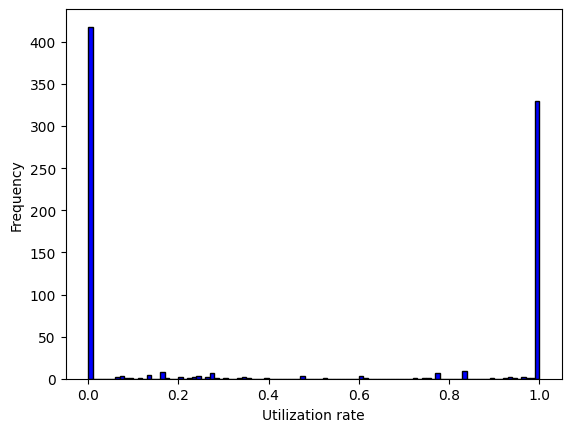

In [147]:
# Create a histogram showing the distribution of utilization rate of the edges, i.e., the flow divided by the capacity
utilization_rates = [flow_dict[from_node][to_node] / G_simple_directed[from_node][to_node]['max_cap_M_m3_per_d'] for from_node, to_node in G_simple_directed.edges]
plt.hist(utilization_rates, bins=100, color='blue', edgecolor='black')
plt.xlabel('Utilization rate')
plt.ylabel('Frequency')
plt.show()

# Ye et al. (2022): "Topology Analysis of Natural Gas Pipeline Networks Based on Complex Network Theory"

## Creating the network of natural gas pipelines, along with random and regulated benchmark networks

In [163]:
# Create an undirected graph from the G_multi_digraph graph
G_actual = nx.Graph(G_multi_digraph)

# Create a random connected graph with the same number of nodes and edges as the G_actual graph
G_random = nx.gnm_random_graph(G_actual.number_of_nodes(), G_actual.number_of_edges())

# Create a regulated graph with the same number of nodes and edges as the G_multi_graph graph
G_regulated = nx.random_regular_graph(3, G_actual.number_of_nodes())

Number of edges in G_actual: 789
Number of edges in G_multi_digraph: 989


## Small-world parameters analysis

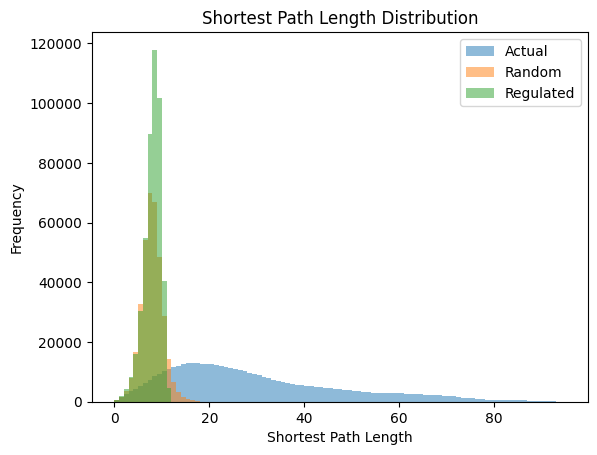

In [149]:
# Compute all pairs shortest path lengths
lengths_actual = dict(nx.all_pairs_shortest_path_length(G_actual))
lengths_random = dict(nx.all_pairs_shortest_path_length(G_random))
lengths_regulated = dict(nx.all_pairs_shortest_path_length(G_regulated))

# Flatten the dictionary to a list of lengths
all_lengths_actual = [length for source in lengths_actual for length in lengths_actual[source].values()]
all_lengths_random = [length for source in lengths_random for length in lengths_random[source].values()]
all_lengths_regulated = [length for source in lengths_regulated for length in lengths_regulated[source].values()]

# Plot the distributions
fig, ax = plt.subplots()
ax.hist(all_lengths_actual, bins=range(0, max(all_lengths_actual) + 1), alpha=0.5, label='Actual')
ax.hist(all_lengths_random, bins=range(0, max(all_lengths_random) + 1), alpha=0.5, label='Random')
ax.hist(all_lengths_regulated, bins=range(0, max(all_lengths_regulated) + 1), alpha=0.5, label='Regulated')
ax.legend(loc='upper right')
plt.xlabel('Shortest Path Length')
plt.ylabel('Frequency')
plt.title('Shortest Path Length Distribution')
plt.show()

In [150]:
# Compute the clustering coefficient of the graphs
clustering_actual = nx.average_clustering(G_actual)
clustering_random = nx.average_clustering(G_random)
clustering_regulated = nx.average_clustering(G_regulated)

# Compute the average shortest path length of the graphs by using the computation above
average_shortest_path_length_actual = np.mean(all_lengths_actual)
average_shortest_path_length_random = np.mean(all_lengths_random)
average_shortest_path_length_regulated = np.mean(all_lengths_regulated)

# Print the output of the computations in a tabular format
print('Graph Type | Clustering Coefficient | Average Shortest Path Length')
print('Actual     | {:<22} | {:<26}'.format(clustering_actual, average_shortest_path_length_actual))
print('Random     | {:<22} | {:<26}'.format(clustering_random, average_shortest_path_length_random))
print('Regulated  | {:<22} | {:<26}'.format(clustering_regulated, average_shortest_path_length_regulated))


Graph Type | Clustering Coefficient | Average Shortest Path Length
Actual     | 0.02133138969873664    | 29.308884903399093        
Random     | 0.003765792031098153   | 7.419156571454045         
Regulated  | 0.0014577259475218659  | 7.484126511912553         


## Scale-free parameters analysis

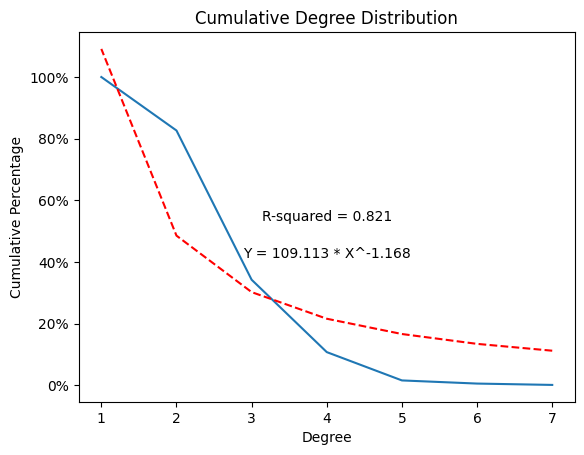

/var/folders/vr/0qryf_g13n11tpz1djg9ycb80000gn/T/ipykernel_17340/3223355269.py:35: RuntimeWarning: divide by zero encountered in power
  return np.where(x == 0, 0, a * x ** b)


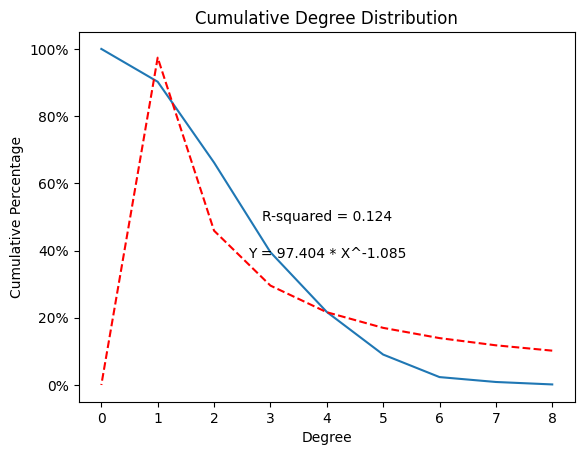

In [151]:
# Function to plot the cumulative degree distribution of a graph
def plot_cumulative_degree_distribution(graph):
    
    # Compute the degree sequence of the graph
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degreeCount = dict()

    # Count the number of nodes with each degree
    for degree in degree_sequence:
        degreeCount[degree] = degreeCount.get(degree, 0) + 1

    cumulative_degreeCount = {}
    cumulative_count = 0
    total_count = sum(degreeCount.values())

    # Compute the cumulative percentage of nodes with each degree
    for degree in degreeCount:
        cumulative_count += degreeCount[degree]
        cumulative_degreeCount[degree] = cumulative_count / total_count * 100

    # Plot the cumulative degree distribution
    plt.plot(list(cumulative_degreeCount.keys()), list(cumulative_degreeCount.values()))
    plt.xlabel('Degree')
    plt.ylabel('Cumulative Percentage')
    plt.title('Cumulative Degree Distribution')

    # Add percentage sign to y-axis
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    # Add a power law fit to the plot
    x = np.array(list(cumulative_degreeCount.keys()))
    y = np.array(list(cumulative_degreeCount.values()))

    def power_law(x, a, b):
        return np.where(x == 0, 0, a * x ** b)

    # Fit the power law function to the data
    popt, pcov = opt.curve_fit(power_law, x, y)
    plt.plot(x, power_law(x, *popt), 'r--', label='a=%5.3f, b=%5.3f' % tuple(popt))

    # Compute the r-squared value
    residuals = y - power_law(x, *popt)
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Display the r-squared value
    plt.text(0.5, 0.5, 'R-squared = %5.3f' % r_squared, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    # Display the definition of the power law function
    plt.text(0.5, 0.4, 'Y = %5.3f * X^%5.3f' % tuple(popt), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    # Show the plot
    plt.show()

# Plot the cumulative degree distribution of the actual graph
plot_cumulative_degree_distribution(G_actual)

# Plot the cumulative degree distribution of the random graph
plot_cumulative_degree_distribution(G_random)

In [152]:
# # Compute the edge density, edge per note ratio, center-point dominance, assortative coefficient, network diameter and algebraic connectivity the three graphs
# edge_density_actual = nx.density(G_actual)
# edge_density_random = nx.density(G_random)
# edge_density_regulated = nx.density(G_regulated)

# edge_per_node_ratio_actual = G_actual.number_of_edges() / G_actual.number_of_nodes()
# edge_per_node_ratio_random = G_random.number_of_edges() / G_random.number_of_nodes()
# edge_per_node_ratio_regulated = G_regulated.number_of_edges() / G_regulated.number_of_nodes()

# center_point_dominance_actual = nx.center(G_actual)
# center_point_dominance_random = nx.center(G_random)
# center_point_dominance_regulated = nx.center(G_regulated)

# assortative_coefficient_actual = nx.degree_assortativity_coefficient(G_actual)
# assortative_coefficient_random = nx.degree_assortativity_coefficient(G_random)
# assortative_coefficient_regulated = nx.degree_assortativity_coefficient(G_regulated)

# network_diameter_actual = nx.diameter(G_actual)
# network_diameter_random = nx.diameter(G_random)
# network_diameter_regulated = nx.diameter(G_regulated)

# algebraic_connectivity_actual = nx.algebraic_connectivity(G_actual)
# algebraic_connectivity_random = nx.algebraic_connectivity(G_random)
# algebraic_connectivity_regulated = nx.algebraic_connectivity(G_regulated)

# # Print the output of the computations in a tabular format
# print('Graph Type | Edge Density | Edge per Node Ratio | Center Point Dominance | Assortative Coefficient | Network Diameter | Algebraic Connectivity')
# print('Actual     | {:<12} | {:<19} | {:<19} | {:<23} | {:<17} | {:<23}'.format(edge_density_actual, edge_per_node_ratio_actual, center_point_dominance_actual, assortative_coefficient_actual, network_diameter_actual, algebraic_connectivity_actual))
# print('Random     | {:<12} | {:<19} | {:<19} | {:<23} | {:<17} | {:<23}'.format(edge_density_random, edge_per_node_ratio_random, center_point_dominance_random, assortative_coefficient_random, network_diameter_random, algebraic_connectivity_random))
# print('Regulated  | {:<12} | {:<19} | {:<19} | {:<23} | {:<17} | {:<23}'.format(edge_density_regulated, edge_per_node_ratio_regulated, center_point_dominance_regulated, assortative_coefficient_regulated, network_diameter_regulated, algebraic_connectivity_regulated))


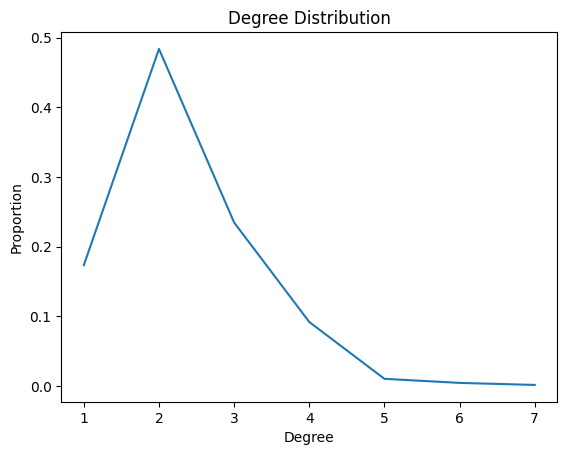

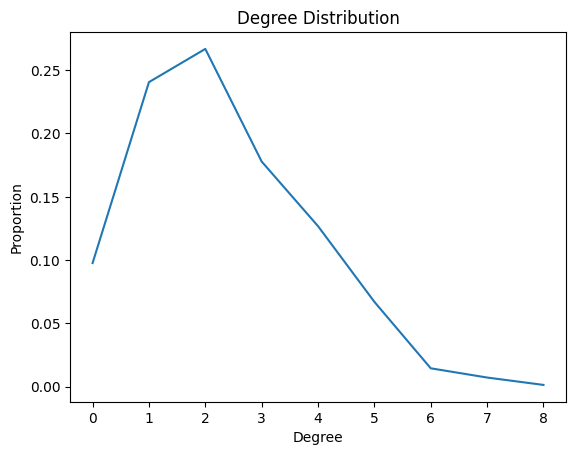

In [153]:
def plot_degree_distribution(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degreeCount = dict()
    total_count = len(degree_sequence)  # Calculate the total count
    for degree in degree_sequence:
        degreeCount[degree] = degreeCount.get(degree, 0) + 1
    degreeProportion = {degree: count / total_count for degree, count in degreeCount.items()}

    plt.plot(list(degreeProportion.keys()), list(degreeProportion.values()))
    plt.xlabel('Degree')
    plt.ylabel('Proportion')
    plt.title('Degree Distribution')
    plt.show()

plot_degree_distribution(G_actual)
plot_degree_distribution(G_random)

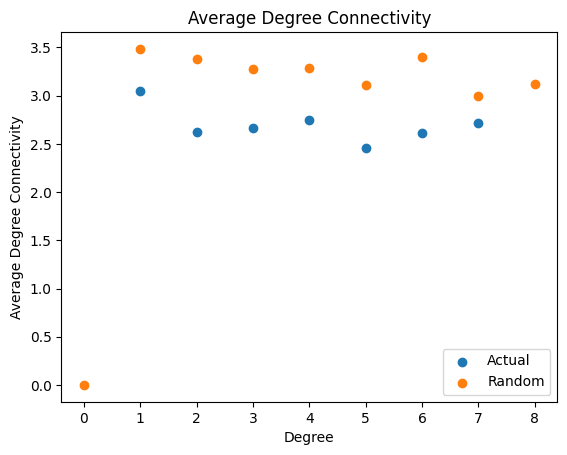

In [154]:
average_degree_actual = nx.average_degree_connectivity(G_actual)
average_degree_random = nx.average_degree_connectivity(G_random)

plt.scatter(list(average_degree_actual.keys()), list(average_degree_actual.values()), label='Actual')
plt.scatter(list(average_degree_random.keys()), list(average_degree_random.values()), label='Random')

plt.xlabel('Degree')
plt.ylabel('Average Degree Connectivity')
plt.title('Average Degree Connectivity')
plt.legend()
plt.show()

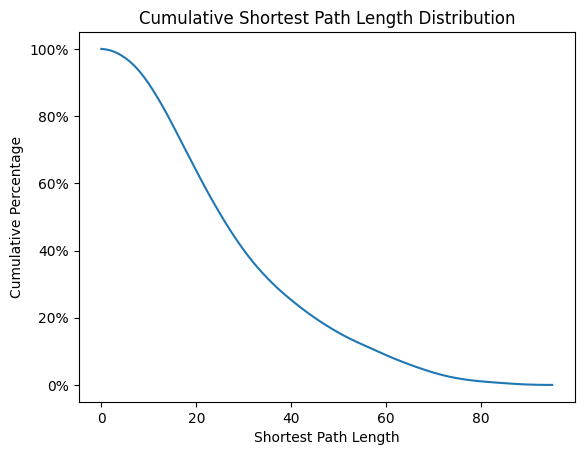

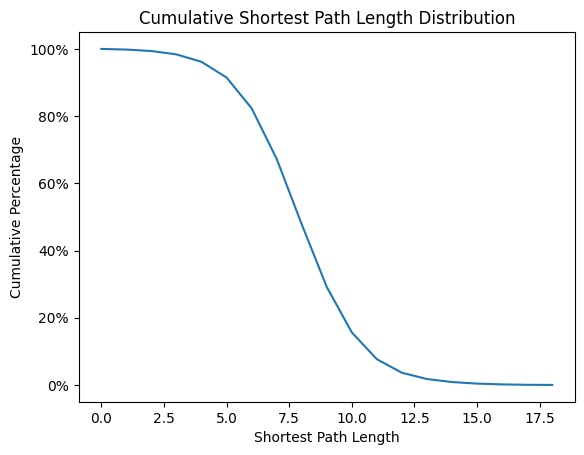

In [155]:
def plot_cumulative_shortest_path_lengths(graph):
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(graph))
    shortest_path_lengths = [length for source in shortest_path_lengths for length in shortest_path_lengths[source].values()]
    shortest_path_lengths = sorted(shortest_path_lengths, reverse=True)
    shortest_path_lengths_count = dict()
    for length in shortest_path_lengths:
        shortest_path_lengths_count[length] = shortest_path_lengths_count.get(length, 0) + 1
    cumulative_shortest_path_lengths_count = {}
    cumulative_count = 0
    total_count = sum(shortest_path_lengths_count.values())  # Calculate the total count
    for length in shortest_path_lengths_count:
        cumulative_count += shortest_path_lengths_count[length]
        cumulative_shortest_path_lengths_count[length] = cumulative_count / total_count * 100  # Convert count to percentage
    plt.plot(list(cumulative_shortest_path_lengths_count.keys()), list(cumulative_shortest_path_lengths_count.values()))
    plt.xlabel('Shortest Path Length')
    plt.ylabel('Cumulative Percentage')
    plt.title('Cumulative Shortest Path Length Distribution')
    # Add percentage sign to y-axis
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

plot_cumulative_shortest_path_lengths(G_actual)
plot_cumulative_shortest_path_lengths(G_random)

## Bridge edge analysis

In [156]:
# Calculate the number of edges that needs to be removed to disconnect the graph
edge_connectivity_actual = nx.edge_connectivity(G_actual)
edge_connectivity_random = nx.edge_connectivity(G_random)
print('Edge Connectivity Actual:', edge_connectivity_actual)
print('Edge Connectivity Random:', edge_connectivity_random)

Edge Connectivity Actual: 1
Edge Connectivity Random: 0


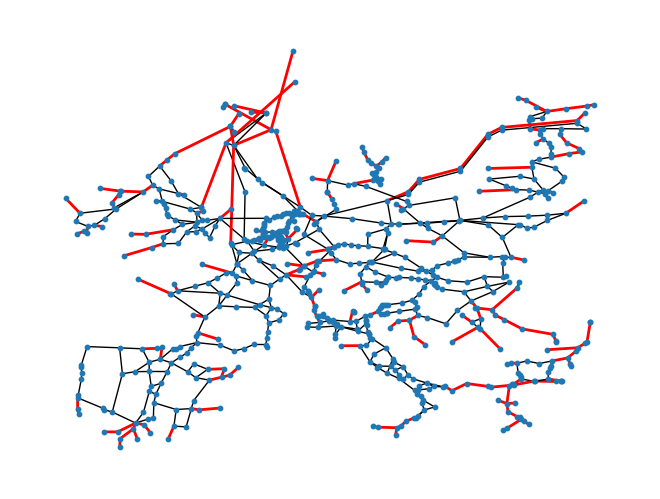

In [157]:
# Identify and plot the bridge edges of the G_actual graph
bridge_edges = list(nx.bridges(G_actual))
G_bridge = nx.Graph(G_actual)
for edge in bridge_edges:
    G_bridge[edge[0]][edge[1]]['color'] = 'red'
    G_bridge[edge[0]][edge[1]]['width'] = 2

edge_colors = [G_bridge[edge[0]][edge[1]]['color'] if 'color' in G_bridge[edge[0]][edge[1]] else 'black' for edge in G_bridge.edges]
edge_widths = [G_bridge[edge[0]][edge[1]]['width'] if 'width' in G_bridge[edge[0]][edge[1]] else 1 for edge in G_bridge.edges]
nx.draw(G_bridge, pos, with_labels=False, node_size=10, edge_color=edge_colors, width=edge_widths)
plt.show()

# Carvalho et al. (2009): "Robustness of trans-European gas networks"

## Topological analysis

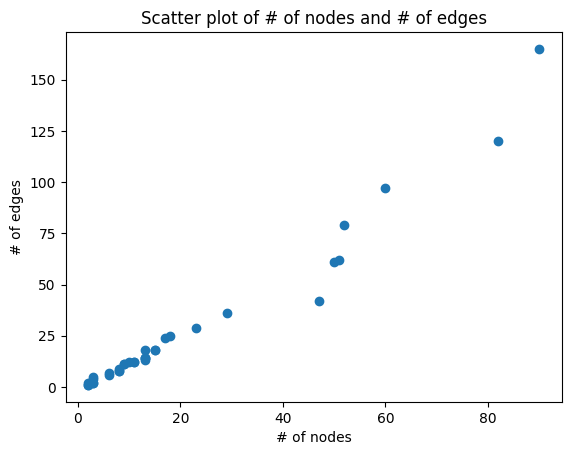

In [158]:
# Make a scatter plot with "# of nodes" on the x-axis and "# of edges" on the y-axis. Plot the countries as points.

# Count the number of nodes and edges in each country
nodes_per_country = nodes_df['country_code'].value_counts()
edges_per_country = pipe_segments_df['from_country_code'].value_counts()

# Ensure that the index of the two series are the same
nodes_per_country = nodes_per_country[nodes_per_country.index.isin(edges_per_country.index)]
edges_per_country = edges_per_country[edges_per_country.index.isin(nodes_per_country.index)]

# Plot the scatter plot
fig, ax = plt.subplots()
ax.scatter(nodes_per_country, edges_per_country)
ax.set_xlabel('# of nodes')
ax.set_ylabel('# of edges')
ax.set_title('Scatter plot of # of nodes and # of edges')
plt.show()

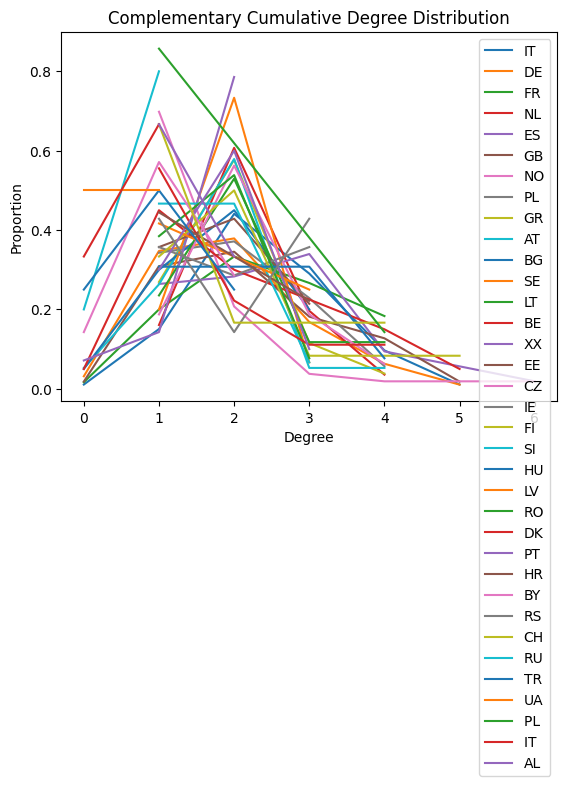

In [159]:
# Plot the complementary cumulative degree distribution of the G_actual graph, split into different countries
fig, ax = plt.subplots()
for country in nodes_per_country.index:
    nodes_in_country = nodes_df[nodes_df['country_code'] == country]
    edges_in_country = pipe_segments_df[pipe_segments_df['from_country_code'] == country]
    G_in_country = nx.Graph()
    for index, row in nodes_in_country.iterrows():
        G_in_country.add_node(row['id'])
    for index, row in edges_in_country.iterrows():
        G_in_country.add_edge(row['from_node_id'], row['to_node_id'])
    degree_sequence = sorted([d for n, d in G_in_country.degree()], reverse=True)
    degreeCount = dict()
    total_count = len(degree_sequence)  # Calculate the total count
    for degree in degree_sequence:
        degreeCount[degree] = degreeCount.get(degree, 0) + 1
    degreeProportion = {degree: count / total_count for degree, count in degreeCount.items()}
    ax.plot(list(degreeProportion.keys()), list(degreeProportion.values()), label=country)
ax.set_xlabel('Degree')
ax.set_ylabel('Proportion')
ax.set_title('Complementary Cumulative Degree Distribution')
ax.legend()
plt.show()

## Generalized betweenness centrality

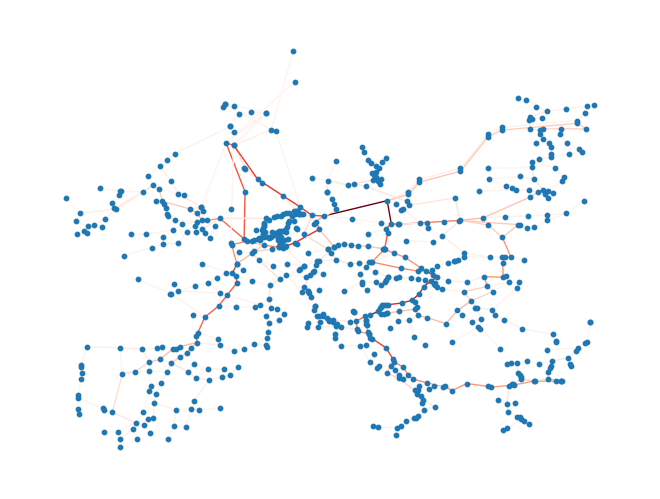

In [160]:
# Let the betweenness centrality of edge e_ij be defined as the relative number of shortest paths between all pairs of nodes which pass through e_ij
# Compute the betweenness centrality of the edges of the G_actual graph
edge_betweenness_centrality = nx.edge_betweenness_centrality(G_actual, normalized=True)

# Plot the G_actual graph, but this time around, let the color of the edges be proportional to the betweenness centrality of the edges
edge_colors = [edge_betweenness_centrality[edge] for edge in G_actual.edges]
nx.draw(G_actual, pos, with_labels=False, node_size=10, edge_color=edge_colors, edge_cmap=plt.cm.Reds)
# Layer a map of Europe on top of the graph
plt.show()